<a href="https://www.kaggle.com/code/prabeshsagarbaral/devanagarimnist?scriptVersionId=261713531" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Understanding Neural Networks: A Complete Implementation from Scratch

This notebook demonstrates a complete neural network implementation using only NumPy to classify Devanagari characters. We'll build everything from scratch to understand how neural networks truly work under the hood.

## Why Build from Scratch?
- **Deep Understanding**: See exactly how forward propagation, backpropagation, and gradient descent work
- **No Black Box**: Every mathematical operation is visible and explainable
- **Foundation Building**: Understanding these concepts makes advanced frameworks (TensorFlow, PyTorch) much clearer

Let's start by loading our data and understanding what we're working with.

In [2]:
# Load datasets
trainSet = pd.read_csv('/kaggle/input/mnistdevanagari/trainDataMNIST.csv', low_memory=False)
testSet = pd.read_csv('/kaggle/input/mnistdevanagari/testDataMNIST.csv', low_memory=False)

# Data Loading and Initial Exploration

## What We Just Did:
- Loaded training and test datasets containing Devanagari character images
- Each row represents a 32x32 pixel image (1024 pixel values) plus labels

## Why Separate Train/Test Sets?
- **Training Set**: Used to teach the neural network patterns
- **Test Set**: Used to evaluate how well the network generalizes to unseen data
- This prevents **overfitting** - memorizing training data instead of learning patterns

## Data Structure:
- **Images**: 32x32 = 1024 pixel values (features)
- **Labels**: Character classifications (what each image represents)
- **Phonetics**: Sound representations (we'll remove this)

## Alternative Approaches:
- **Data Augmentation**: Rotating, scaling images to increase dataset size
- **Normalization**: Scaling pixel values
- **Cross-Validation**: Multiple train/test splits for better evaluation

In [3]:
# Remove unnecessary columns (keep only pixel data and Devanagari labels)
trainSet.drop(columns=['Label', 'Phonetics'], inplace=True)
testSet.drop(columns=['Label', 'Phonetics'], inplace=True)

# Create mapping from character labels to numerical indices
labelMap = {label:index for index, label in enumerate(trainSet["Devanagari Label"].unique())}

# Shuffle datasets to randomize training order
trainSet = trainSet.sample(frac=1, random_state=42).reset_index(drop=True)
testSet = testSet.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features (pixel values) from targets (labels)
xTrain = trainSet.drop(columns=['Devanagari Label']).to_numpy()
xTest = testSet.drop(columns=['Devanagari Label']).to_numpy()

# Convert text labels to numerical indices
yTrain = trainSet["Devanagari Label"].map(labelMap).to_numpy()
yTest = testSet["Devanagari Label"].map(labelMap).to_numpy()

# Convert to one-hot encoding (required for multi-class classification)
numClasses = len(labelMap)
yTrain = np.eye(numClasses)[yTrain]  # Creates binary matrix: [0,0,1,0...] for each class
yTest = np.eye(numClasses)[yTest]

# Data Preprocessing: The Foundation of Success

## What We Just Accomplished:

### 1. **Label Encoding & One-Hot Conversion**
```python
labelMap = {label:index for index, label in enumerate(trainSet["Devanagari Label"].unique())}
yTrain = np.eye(numClasses)[yTrain]
```

**Why One-Hot Encoding?**
- Neural networks work with numbers, not text labels
- One-hot prevents the model from thinking "label 5 > label 2" (no inherent order)
- Creates probability distributions: `[0,0,1,0,0]` means "100% confident it's class 2"

**Alternative**: Label encoding (0,1,2...) works for some algorithms but causes ordinal bias

### 2. **Data Shuffling**
```python
trainSet = trainSet.sample(frac=1, random_state=42)
```

**Why Shuffle?**
- Prevents the model from learning order patterns instead of image patterns
- Ensures random mini-batches during training
- `random_state=42` makes results reproducible

**Alternative**: Shuffle during each epoch (we do this in training loop)

### 3. **Feature-Target Separation**
- **X (Features)**: The 1024 pixel values that describe each image
- **Y (Targets)**: The one-hot encoded labels we want to predict

## The Neural Network's Job:
Learn a function: `f(pixels) = character_class`

In [4]:
class NeuralNetwork:
    def __init__(self, inputData, outputData, x_val, y_val, layers, learningRate):
        # Store training and validation data
        self.inputData = inputData
        self.outputData = outputData
        self.x_val = x_val
        self.y_val = y_val
        self.layers = layers
        self.learningRate = learningRate
        
        # Initialize parameter storage
        self.weights = []
        self.biases = []
        self.lossHistory = []

        # Calculate layer sizes: input -> hidden layers -> output
        layerSizes = [inputData.shape[1]] + layers + [outputData.shape[1]]
        
        # Initialize weights and biases for each layer connection
        for i in range(len(layerSizes) - 1):
            # Xavier initialization: prevents vanishing/exploding gradients
            limit = np.sqrt(6.0 / (layerSizes[i] + layerSizes[i + 1]))
            weightMatrix = np.random.uniform(-limit, limit, (layerSizes[i], layerSizes[i + 1])).astype(np.float32)
            biasVector = np.zeros((1, layerSizes[i + 1]), dtype=np.float32)
            self.weights.append(weightMatrix)
            self.biases.append(biasVector)

    def __call__(self, epochs, batch_size=64):
        """Main training loop - processes data in mini-batches"""
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        for epoch in range(epochs):
            # Shuffle training data each epoch for better convergence
            indices = np.random.permutation(self.inputData.shape[0])
            
            epoch_loss = 0.0
            
            # Process data in mini-batches
            for i in range(0, self.inputData.shape[0], batch_size):
                # Extract current batch
                batch_indices = indices[i:i+batch_size]
                X_batch = self.inputData[batch_indices]
                y_batch = self.outputData[batch_indices]

                # Forward pass: compute predictions
                activations = self.forward(X_batch)
                
                # Compute loss for this batch
                loss = self.computeLoss(y_batch, activations[-1])
                epoch_loss += loss * len(X_batch)
                
                # Backward pass: update weights based on error
                self.gradientDescent(y_batch, activations)

            # Evaluate performance on full datasets (for tracking progress)
            train_preds = self.forward(self.inputData)[-1]
            val_preds = self.forward(self.x_val)[-1]

            # Store metrics for plotting
            history['train_loss'].append(self.computeLoss(self.outputData, train_preds))
            history['val_loss'].append(self.computeLoss(self.y_val, val_preds))
            history['train_acc'].append(self._accuracy(self.outputData, train_preds))
            history['val_acc'].append(self._accuracy(self.y_val, val_preds))

            # Print progress periodically
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch + 1}/{epochs} -> "
                      f"Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f} | "
                      f"Train Acc: {history['train_acc'][-1]:.2%}, Val Acc: {history['val_acc'][-1]:.2%}")
                
        return history
    
    def _accuracy(self, y_true_one_hot, y_pred_probs):
        """Calculate accuracy: percentage of correct predictions"""
        return np.mean(np.argmax(y_true_one_hot, axis=1) == np.argmax(y_pred_probs, axis=1))
    
    def predict(self, X):
        """Make predictions on new data"""
        return np.argmax(self.forward(X)[-1], axis=1)
    
    def softmax(self, z):
        """Convert logits to probabilities (used in output layer)"""
        # Subtract max for numerical stability (prevents overflow)
        z_stable = z - np.max(z, axis=1, keepdims=True)
        
        # Clip extreme values to prevent exp overflow
        z_stable = np.clip(z_stable, -700, 700)
        
        # Apply softmax formula
        exp_z = np.exp(z_stable)
        softmax_output = exp_z / np.sum(exp_z, axis=1, keepdims=True)
        
        # Ensure numerical stability (avoid log(0) in loss calculation)
        return np.clip(softmax_output, 1e-15, 1.0 - 1e-15)

    def tanh(self, z):
        """Hyperbolic tangent activation: squashes values to (-1, 1)"""
        return np.tanh(np.clip(z, -500, 500))

    def tanhDerivative(self, a):
        """Derivative of tanh for backpropagation"""
        return 1.0 - a * a  # More efficient than np.power(a, 2)
    
    def forward(self, X):
        """Forward propagation: compute network output"""
        activations = [X]  # Store activations for each layer
        
        for i in range(len(self.weights)):
            # Linear transformation: z = Wx + b
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            
            # Apply activation function
            if i == len(self.weights) - 1:  # Output layer: use softmax
                a = self.softmax(z)
            else:  # Hidden layers: use tanh
                a = self.tanh(z)
            
            activations.append(a)
        
        return activations
    
    def computeLoss(self, yTrue, yPred):
        """Cross-entropy loss: measures prediction error"""
        # Clip predictions to prevent log(0) which is undefined
        yPred_clipped = np.clip(yPred, 1e-15, 1.0 - 1e-15)
        
        # Cross-entropy formula: -sum(y_true * log(y_pred))
        return -np.mean(np.sum(yTrue * np.log(yPred_clipped), axis=1))

    def gradientDescent(self, yTrue, activations):
        """Backpropagation: update weights to minimize error"""
        m = yTrue.shape[0]  # Batch size
        
        # Start with output layer error
        delta = activations[-1] - yTrue  # Difference between prediction and truth
        
        # Propagate error backward through all layers
        for i in reversed(range(len(self.weights))):
            # Compute gradients (how much to change weights/biases)
            dw = np.dot(activations[i].T, delta) / m  # Weight gradients
            db = np.mean(delta, axis=0, keepdims=True)  # Bias gradients
            
            # Update parameters using gradient descent
            self.weights[i] -= self.learningRate * dw
            self.biases[i] -= self.learningRate * db
            
            # Compute error for previous layer (chain rule)
            if i > 0:
                delta = np.dot(delta, self.weights[i].T) * self.tanhDerivative(activations[i])

# Neural Network Architecture: The Brain's Blueprint

## What We're Building:
A **feedforward neural network** with these components:

### **Layers Structure:**
```
Input Layer (1024 neurons) → Hidden Layer 1 (512) → Hidden Layer 2 (256) → Hidden Layer 3 (128) → Output Layer (46)
```

### **Key Concepts:**

#### **1. Neurons (Nodes)**
- Simple processing units that receive inputs, apply weights, and produce outputs
- Each connection has a **weight** (importance) and each neuron has a **bias** (threshold)

#### **2. Activation Functions**
- **Tanh (Hidden Layers)**: Squashes values between -1 and 1, helps with gradient flow
- **Softmax (Output Layer)**: Converts outputs to probabilities that sum to 1

#### **3. Forward Propagation**
Information flows from input → hidden layers → output
```
output = activation(weights × input + bias)
```

#### **4. Backpropagation**
Error flows backward to update weights and biases
```
new_weight = old_weight - learning_rate × gradient
```

## Why This Architecture?
- **Deep Network**: Multiple layers can learn complex patterns
- **Decreasing Size**: 512→256→128 creates a "funnel" effect, extracting key features
- **46 Output Neurons**: One for each Devanagari character class

## Alternative Architectures:
- **Convolutional Neural Networks (CNNs)**: Better for images, preserve spatial relationships
- **Shallow Networks**: Fewer layers, faster but less expressive
- **Different Sizes**: More neurons = more capacity but slower training

In [5]:
# Create neural network: 1024 input -> 512 -> 256 -> 128 -> 46 output neurons
nn = NeuralNetwork(xTrain, yTrain, xTest, yTest, layers=[512, 256, 128], learningRate=0.01)

# Train for 100 epoch with batch size 64 (returns training history)
history = nn(epochs=100, batch_size=64)

Epoch 1/100 -> Train Loss: 1.9485, Val Loss: 1.9590 | Train Acc: 52.27%, Val Acc: 51.64%
Epoch 10/100 -> Train Loss: 1.1422, Val Loss: 1.1652 | Train Acc: 67.97%, Val Acc: 67.09%
Epoch 20/100 -> Train Loss: 0.8513, Val Loss: 0.8865 | Train Acc: 75.65%, Val Acc: 74.59%
Epoch 30/100 -> Train Loss: 0.7077, Val Loss: 0.7511 | Train Acc: 79.60%, Val Acc: 78.22%
Epoch 40/100 -> Train Loss: 0.5659, Val Loss: 0.6122 | Train Acc: 83.52%, Val Acc: 82.29%
Epoch 50/100 -> Train Loss: 0.4997, Val Loss: 0.5623 | Train Acc: 85.21%, Val Acc: 83.49%
Epoch 60/100 -> Train Loss: 0.4149, Val Loss: 0.4933 | Train Acc: 87.62%, Val Acc: 85.33%
Epoch 70/100 -> Train Loss: 0.4088, Val Loss: 0.4782 | Train Acc: 87.59%, Val Acc: 85.58%
Epoch 80/100 -> Train Loss: 0.3455, Val Loss: 0.4289 | Train Acc: 89.60%, Val Acc: 87.17%
Epoch 90/100 -> Train Loss: 0.3431, Val Loss: 0.4256 | Train Acc: 89.63%, Val Acc: 87.39%
Epoch 100/100 -> Train Loss: 0.2845, Val Loss: 0.3830 | Train Acc: 91.40%, Val Acc: 88.54%


# Understanding the Neural Network Implementation

## Core Components Explained:

### **1. Weight Initialization (Xavier/Glorot)**
```python
limit = np.sqrt(6.0 / (layerSizes[i] + layerSizes[i + 1]))
weightMatrix = np.random.uniform(-limit, limit, ...)
```

**Why Not Random?**
- Pure random weights can cause **vanishing gradients** (too small) or **exploding gradients** (too large)
- Xavier initialization keeps gradient magnitudes stable across layers
- **Alternative**: He initialization (better for ReLU), zero initialization (bad - neurons learn identically)

### **2. Mini-Batch Training**
We don't use the entire dataset at once. Instead:
- **Batch Size 64**: Process 64 images at a time
- **Faster**: Less memory usage, faster updates
- **Better Generalization**: Noise in small batches acts as regularization

**Alternatives**:
- **Batch Gradient Descent**: Use entire dataset (slow, smooth)
- **Stochastic Gradient Descent**: Use 1 sample (fast, noisy)
- **Different Batch Sizes**: 32, 128, 256 (trade-off between speed and stability)

### **3. Forward Pass Mathematics**
For each layer: `output = activation(input × weights + bias)`

**Why Matrix Multiplication?**
- Efficiently computes all neuron outputs simultaneously
- Each weight connects one input to one output neuron
- Bias adds a constant shift to help with learning

### **4. Loss Function (Cross-Entropy)**
```python
loss = -np.mean(np.sum(yTrue * np.log(yPred), axis=1))
```

**What This Means:**
- Measures "how wrong" our predictions are
- **Lower loss = Better predictions**
- Cross-entropy works well with probability outputs (softmax)

**Alternative Loss Functions**:
- **Mean Squared Error**: For regression problems
- **Hinge Loss**: For support vector machines
- **Focal Loss**: For imbalanced datasets

### **5. Backpropagation (The Learning Process)**
```python
delta = activations[-1] - yTrue  # Start with output error
dw = np.dot(activations[i].T, delta) / m  # Compute weight gradients
self.weights[i] -= self.learningRate * dw  # Update weights
```

**The Chain Rule in Action:**
1. **Calculate Error**: How wrong was each output?
2. **Propagate Backward**: Which weights caused this error?
3. **Update Weights**: Adjust weights to reduce error

**Why Learning Rate Matters:**
- **Too High (0.1+)**: Weights jump around, never converge
- **Too Low (0.001)**: Learning is very slow
- **Just Right (0.01)**: Steady progress toward optimal weights

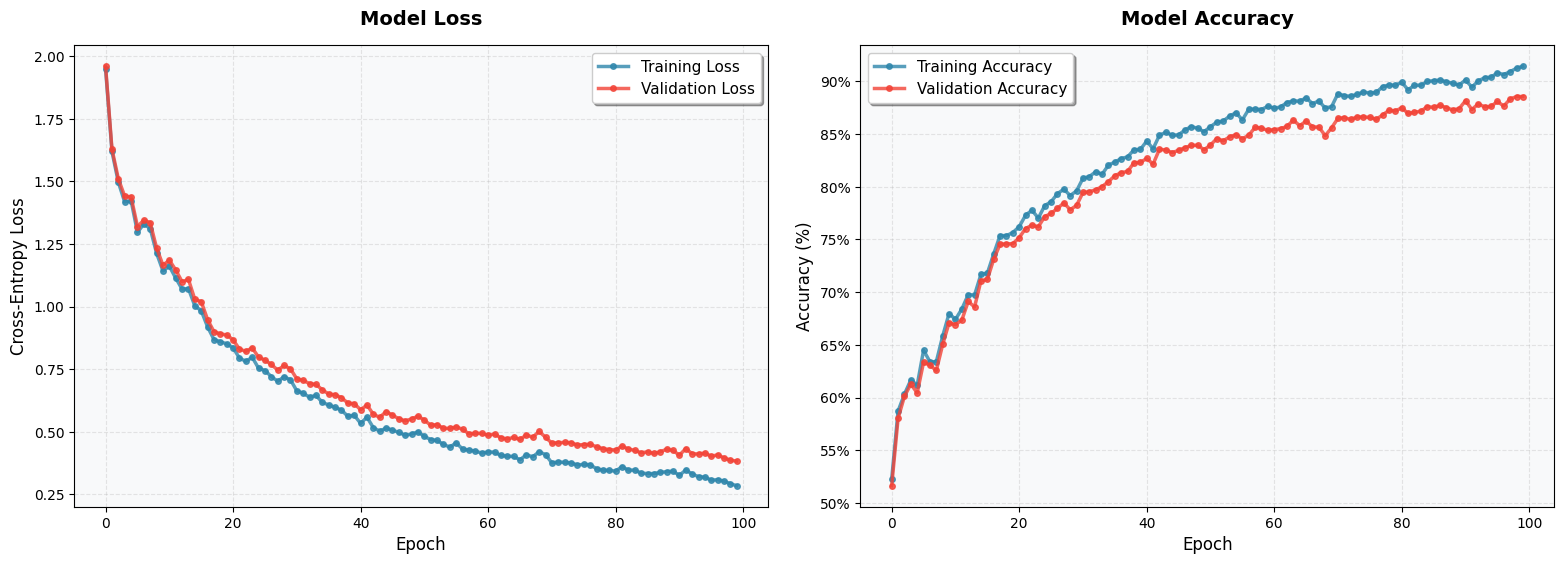

In [6]:
def plot_history(history):
    """
    Optimized plotting function for training metrics with enhanced visual clarity
    """
    # Create subplots with optimized layout
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    epochs_range = range(len(history['train_loss']))

    # --- Enhanced Loss Plot ---
    ax1.plot(epochs_range, history['train_loss'], 'o-', label='Training Loss', 
             color='#2E86AB', linewidth=2.5, markersize=4, alpha=0.8)
    ax1.plot(epochs_range, history['val_loss'], 'o-', label='Validation Loss', 
             color='#F24236', linewidth=2.5, markersize=4, alpha=0.8)
    
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Cross-Entropy Loss', fontsize=12)
    ax1.legend(frameon=True, fancybox=True, shadow=True, fontsize=11)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_facecolor('#f8f9fa')

    # --- Enhanced Accuracy Plot ---
    ax2.plot(epochs_range, history['train_acc'], 'o-', label='Training Accuracy', 
             color='#2E86AB', linewidth=2.5, markersize=4, alpha=0.8)
    ax2.plot(epochs_range, history['val_acc'], 'o-', label='Validation Accuracy', 
             color='#F24236', linewidth=2.5, markersize=4, alpha=0.8)
    
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(frameon=True, fancybox=True, shadow=True, fontsize=11)
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.set_facecolor('#f8f9fa')
    
    # Format y-axis as percentage
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    # Optimize layout and display
    plt.tight_layout(pad=2.0)
    plt.show()

# Plot training history with enhanced visualization
plot_history(history)

# Training Process: How the Network Learns

## What Just Happened During Training:

### **Epoch-by-Epoch Learning:**
1. **Forward Pass**: Network makes predictions on all training data
2. **Loss Calculation**: Measure how wrong the predictions were
3. **Backward Pass**: Calculate which weights need adjustment
4. **Weight Updates**: Adjust weights to reduce future errors
5. **Repeat**: Process continues until convergence or max epochs

### **Key Metrics We Track:**

#### **Loss (Cross-Entropy)**
- **Training Loss**: Error on data the network has seen
- **Validation Loss**: Error on unseen test data
- **Goal**: Both should decrease over time
- **Warning Signs**: If validation loss increases while training loss decreases = overfitting

#### **Accuracy**
- **Percentage of correct predictions**
- More intuitive than loss values
- **Training Accuracy**: How well we memorized training data
- **Validation Accuracy**: How well we generalize to new data

### **What Makes Training Successful:**

#### **Gradient Descent Optimization**
- **Small Steps**: Learning rate controls step size in weight space
- **Direction**: Gradients point toward steepest error reduction
- **Momentum**: Could add momentum to avoid local minima (not implemented here)

#### **Batch Processing Benefits**
- **Efficiency**: Process multiple samples simultaneously
- **Stability**: Average gradients across batch reduce noise
- **Memory**: Use GPU memory effectively

### **Alternative Training Strategies:**
- **Adam Optimizer**: Adaptive learning rates per parameter
- **Learning Rate Scheduling**: Start high, decrease over time  
- **Early Stopping**: Stop training when validation loss stops improving
- **Dropout**: Randomly disable neurons to prevent overfitting

# Interpreting Training Results: What the Graphs Tell Us

## Understanding Your Training Curves:

### **Loss Curve Analysis:**
- **Decreasing Trend**: Network is learning patterns
- **Training < Validation**: Normal, network sees training data during learning  
- **Gap Too Large**: Possible overfitting - memorizing instead of learning
- **Both Plateau**: Network reached its learning capacity or needs more epochs

### **Accuracy Curve Analysis:**
- **Increasing Trend**: Network making better predictions over time
- **Training > Validation**: Expected, but gap shouldn't be too large
- **Oscillations**: Normal with small batch sizes, adds regularization effect

### **Mathematical Transformation:**
```
Raw Pixels (1024 numbers) → Abstract Features → Character Probability Distribution (46 numbers)
```

## Real-World Performance Considerations:

### **This Implementation vs. Production Systems:**
- **Our Network**: Educational, demonstrates core concepts clearly
- **Production Networks**: CNNs, attention mechanisms, batch normalization, advanced optimizers

### **Improvements for Better Accuracy:**
1. **Architecture**: Convolutional layers preserve spatial relationships
2. **Regularization**: Dropout, batch normalization prevent overfitting  
3. **Data**: More training samples, data augmentation
4. **Optimization**: Adam optimizer, learning rate schedules
5. **Preprocessing**: Better normalization, feature engineering

**Remember**: Every advanced neural network, from GPT to image recognition systems, uses these same fundamental principles - they're just applied at massive scale with architectural innovations.